In [66]:
import warnings
import re
from PIL import Image
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pickle

In [67]:
warnings.filterwarnings('ignore')

In [68]:
# movie titles
mv_genres = pd.read_csv('ml-latest/movies.csv')
mv_genres

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


In [69]:
# movie tags
mv_tags = pd.read_csv('ml-latest/genome-scores.csv')
mv_tags

,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375
2,1,3,0.05425
3,1,4,0.06875
4,1,5,0.16000
...,...,...,...
14862523,187595,1124,0.10700
14862524,187595,1125,0.05850
14862525,187595,1126,0.03800
14862526,187595,1127,0.10225


In [70]:
# movie tag descriptions
mv_tags_desc = pd.read_csv('ml-latest/genome-tags.csv')
mv_tags_desc

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


* Clean Title Column

In [71]:
# clean title in movies.csv file
def movie_title_clean(title):
  
  # search title for (year) pattern
    s = re.search('\(([^)]+)', title)

  # if pattern exists, remove from string
    year = 9999
    if s:

        title = title[:s.span()[0]].strip()
        year = s.group(1)
  
    # check if year is actual year
    if str(year).isdigit():
        year = int(year)
    else:
        year = 9999  
  
  # if ', The' or ', A' is a the end of the string, move it to the front
  # e.g. change "Illusionist, The" to "The Illusionist"
    if title[-5:] == ', The':
        title = 'The ' + title[:-5]
    elif title[-4:] == ', An':
        title = 'An ' + title[:-4]
    elif title[-3:] == ', A':
        title = 'A ' + title[:-3]
    
    return title, year

In [72]:
# clean title and extract release year
mv_genres['title'] = mv_genres['title'].str.strip()
mv_genres['Title_Year'] = mv_genres['title'].map(movie_title_clean)
mv_genres['Title'] = mv_genres['Title_Year'].apply(lambda x: x[0])
mv_genres['Release Year'] = mv_genres['Title_Year'].apply(lambda x: x[1])

In [73]:
mv_genres = mv_genres.drop(['title','Title_Year'],axis=1)

In [74]:
mv_genres

,movieId,genres,Title,Release Year
0,1,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,2,Adventure|Children|Fantasy,Jumanji,1995
2,3,Comedy|Romance,Grumpier Old Men,1995
3,4,Comedy|Drama|Romance,Waiting to Exhale,1995
4,5,Comedy,Father of the Bride Part II,1995
...,...,...,...,...
58093,193876,(no genres listed),The Great Glinka,1946
58094,193878,Comedy,Les tribulations d'une caissière,2011
58095,193880,Drama,Her Name Was Mumu,2016
58096,193882,Adventure|Drama|Horror|Sci-Fi,Flora,2017


* merge tags with movies for tag works

In [75]:
# join dataframes to get tag description and movie title name all in one table
mv_tags_denorm = mv_tags.merge(mv_tags_desc, on = 'tagId').merge(mv_genres, on = 'movieId')

# for each movie, compute the relevance rank of tags so we can eventually rank order tags for each movie
mv_tags_denorm['relevance_rank'] = mv_tags_denorm.groupby("movieId")["relevance"].rank(method = "first", ascending = False).astype('int64')

In [76]:
mv_tags_denorm

,movieId,tagId,relevance,tag,genres,Title,Release Year,relevance_rank
0,1,1,0.02900,007,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,877
1,1,2,0.02375,007 (series),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,942
2,1,3,0.05425,18th century,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,686
3,1,4,0.06875,1920s,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,606
4,1,5,0.16000,1930s,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,362
...,...,...,...,...,...,...,...,...
14862523,187595,1124,0.10700,writing,Action|Adventure|Children|Sci-Fi,Solo: A Star Wars Story,2018,542
14862524,187595,1125,0.05850,wuxia,Action|Adventure|Children|Sci-Fi,Solo: A Star Wars Story,2018,751
14862525,187595,1126,0.03800,wwii,Action|Adventure|Children|Sci-Fi,Solo: A Star Wars Story,2018,881
14862526,187595,1127,0.10225,zombie,Action|Adventure|Children|Sci-Fi,Solo: A Star Wars Story,2018,563


In [77]:
# check out an example of top tags for a movie
mv_tags_denorm[mv_tags_denorm.Title == 'Remember the Titans'][['movieId','genres','Release Year','Title','tag','relevance','relevance_rank']].sort_values(by = 'relevance', ascending = False).head(50)

,movieId,genres,Release Year,Title,tag,relevance,relevance_rank
3958984,3916,Drama,2000,Remember the Titans,race issues,0.99550,1
3958551,3916,Drama,2000,Remember the Titans,football,0.99275,2
3959110,3916,Drama,2000,Remember the Titans,sports,0.98550,3
3958266,3916,Drama,2000,Remember the Titans,based on true story,0.96125,4
3959049,3916,Drama,2000,Remember the Titans,segregation,0.95425,5
3958654,3916,Drama,2000,Remember the Titans,high school,0.95075,6
3958538,3916,Drama,2000,Remember the Titans,feel good movie,0.94975,7
3958261,3916,Drama,2000,Remember the Titans,based on a true story,0.94725,8
3958700,3916,Drama,2000,Remember the Titans,inspiring,0.94150,9
3958539,3916,Drama,2000,Remember the Titans,feel-good,0.93500,10


In [78]:
# compute median relevance score for each relevance rank
mv_tags_rank_agg = mv_tags_denorm.groupby('relevance_rank')['relevance'].median().reset_index(name = 'relevance_median').head(100)

# compute percent change of median relevance score as we go down in rank
mv_tags_rank_agg['relevance_median_pct_chg'] = mv_tags_rank_agg['relevance_median'].pct_change()

Text(0.5, 1.0, '% Change in Tag Relevance Score by Rank')

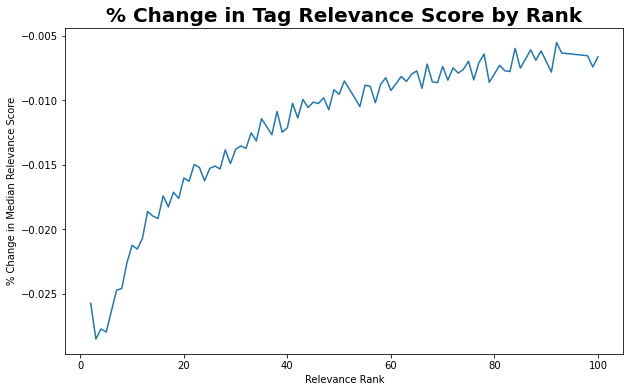

In [79]:
f, ax = plt.subplots(figsize=(10, 6))

ax = sns.lineplot(x="relevance_rank", y="relevance_median_pct_chg", data = mv_tags_rank_agg)
ax.set(ylabel = "% Change in Median Relevance Score")
ax.set(xlabel = "Relevance Rank")
plt.title("% Change in Tag Relevance Score by Rank", fontsize = 20, weight = 'bold')

* we choose to use first 100 tags in relevance rank

In [80]:
# flatten tags table to get a list of top 100 tags for each movie
mv_tags_list = mv_tags_denorm[mv_tags_denorm.relevance_rank <= 100].groupby(['movieId','Title'])['tag'].apply(lambda x: ','.join(x)).reset_index()
#mv_tags_list['tag_list'] = mv_tags_list.tag.map(lambda x: x.split(','))

In [81]:
mv_tags_list

,movieId,Title,tag
0,1,Toy Story,"3d,action,adventure,affectionate,animal movie,animals,animated,animation,based on book,buddy movie,cartoon,catastrophe,cgi,chase,childhood,children,classic,clever,colourful,comedy,computer animation,cool,creativity,cute,cute!,destiny,dialogue,dinosaurs,disney,disney animated feature,entertaining,excellent,excellent script,exciting,family,fantasy,fast paced,feel good movie,feel-good,friendship,fun,fun movie,funny,good,good acting,good action,good soundtrack,good versus evil,great,great ending,great movie,happy ending,heartwarming,highly quotable,humor,humorous,imagination,imdb top 250,intense,interesting,kids,kids and family,light,masterpiece,mentor,monsters,nostalgic,original,original plot,oscar,oscar (best animated feature),oscar (best directing),oscar (best effects - visual effects),oscar (best writing - screenplay written directly for the screen),oscar winner,pixar,pixar animation,quotable,realistic,redemption,runaway,secrets,simple,story,storytelling,suprisingly clever,suspense,sweet,talking animals,talky,technology,touching,toys,unlikely friendships,very funny,very good,visual,visually stunning,whimsical,witty"
1,2,Jumanji,"action,action packed,adaptation,adapted from:book,adventure,alter ego,animal movie,animals,bad cgi,based on a book,based on a video game,based on book,big budget,bullying,catastrophe,cgi,chase,childhood,children,clever,comedy,computer animation,computer game,cool,creativity,destiny,dialogue,dinosaurs,dynamic cgi action,effects,entertaining,exciting,family,fantasy,fantasy world,fast paced,feel-good,fight scenes,first contact,fun,fun movie,girlie movie,good,good action,good versus evil,great,great ending,great movie,happy ending,high fantasy,intense,interesting,island,jungle,kids,kids and family,life philosophy,light,lions,mad scientist,magic,mentor,monkey,monster,mythology,natural disaster,nostalgic,not funny,original,original plot,orphans,oscar (best effects - visual effects),parallel universe,pg,pg-13,predictable,runaway,saturn award (best special effects),scary,science fiction,scifi,silly fun,special effects,spiders,story,storytelling,supernatural,suspense,swashbuckler,technology,time,time travel,transformation,video game,video games,videogame,visual,visuals,weird,witches"
2,3,Grumpier Old Men,"adaptation,adventure,bad plot,beautiful scenery,betrayal,brutality,california,catastrophe,chase,comedy,corruption,crappy sequel,criterion,crude humor,culture clash,death,destiny,dialogue,family,fantasy world,feel good movie,feel-good,fight scenes,fish,foul language,franchise,friendship,fun,fun movie,funny,girlie movie,good,good action,good sequel,good soundtrack,great,great acting,great ending,great movie,greed,gunfight,happy ending,hilarious,imdb top 250,indians,internet,justice,life philosophy,lone hero,marriage,melancholic,mentor,minnesota,multiple storylines,natural disaster,not funny,nudity (full frontal - brief),obsession,original,oscar (best directing),oscar winner,overrated,passionate,pg-13,pornography,predictable,prequel,redemption,relationships,revenge,romance,romantic comedy,runaway,script,sequel,sequels,sexy,shopping,silly,silly fun,slapstick,small town,so bad it's funny,stereotypes,story,storytelling,suprisingly clever,suspense,sweet,touching,twist ending,twists & turns,unfunny,unlikely friendships,vengeance,very funny,very good,wedding,weird,women"
3,4,Waiting to Exhale,"adaptation,adapted from:book,adultery,bad acting,bad plot,based on a book,based on book,betrayal,big budget,bittersweet,book,book was better,books,brutality,cancer,catastrophe,chase,cheating,chick flick,classic car,crude humor,cult film,culture clash,death,destiny,dialogue,divorce,drama,drinking,entirely dialogue,family,fantasy world,feel good movie,feel-good,fight scenes,first contact,friendship,gay,girlie movie,good,good soundtrack,great,great ending,happy ending,heartwarming,horrible,infidelity,interracial romance,justice,life philosophy,light,lone hero,love,love story,marriage,melancholic,men

In [82]:
pd.set_option('display.max_colwidth', -1)

mv_tags_list.loc[mv_tags_list.Title == 'Toy Story', ['movieId','Title','tag']]

,movieId,Title,tag
0,1,Toy Story,"3d,action,adventure,affectionate,animal movie,animals,animated,animation,based on book,buddy movie,cartoon,catastrophe,cgi,chase,childhood,children,classic,clever,colourful,comedy,computer animation,cool,creativity,cute,cute!,destiny,dialogue,dinosaurs,disney,disney animated feature,entertaining,excellent,excellent script,exciting,family,fantasy,fast paced,feel good movie,feel-good,friendship,fun,fun movie,funny,good,good acting,good action,good soundtrack,good versus evil,great,great ending,great movie,happy ending,heartwarming,highly quotable,humor,humorous,imagination,imdb top 250,intense,interesting,kids,kids and family,light,masterpiece,mentor,monsters,nostalgic,original,original plot,oscar,oscar (best animated feature),oscar (best directing),oscar (best effects - visual effects),oscar (best writing - screenplay written directly for the screen),oscar winner,pixar,pixar animation,quotable,realistic,redemption,runaway,secrets,simple,story,storytelling,suprisingly clever,suspense,sweet,talking animals,talky,technology,touching,toys,unlikely friendships,very funny,very good,visual,visually stunning,whimsical,witty"


In [83]:
mv_tags_list

,movieId,Title,tag
0,1,Toy Story,"3d,action,adventure,affectionate,animal movie,animals,animated,animation,based on book,buddy movie,cartoon,catastrophe,cgi,chase,childhood,children,classic,clever,colourful,comedy,computer animation,cool,creativity,cute,cute!,destiny,dialogue,dinosaurs,disney,disney animated feature,entertaining,excellent,excellent script,exciting,family,fantasy,fast paced,feel good movie,feel-good,friendship,fun,fun movie,funny,good,good acting,good action,good soundtrack,good versus evil,great,great ending,great movie,happy ending,heartwarming,highly quotable,humor,humorous,imagination,imdb top 250,intense,interesting,kids,kids and family,light,masterpiece,mentor,monsters,nostalgic,original,original plot,oscar,oscar (best animated feature),oscar (best directing),oscar (best effects - visual effects),oscar (best writing - screenplay written directly for the screen),oscar winner,pixar,pixar animation,quotable,realistic,redemption,runaway,secrets,simple,story,storytelling,suprisingly clever,suspense,sweet,talking animals,talky,technology,touching,toys,unlikely friendships,very funny,very good,visual,visually stunning,whimsical,witty"
1,2,Jumanji,"action,action packed,adaptation,adapted from:book,adventure,alter ego,animal movie,animals,bad cgi,based on a book,based on a video game,based on book,big budget,bullying,catastrophe,cgi,chase,childhood,children,clever,comedy,computer animation,computer game,cool,creativity,destiny,dialogue,dinosaurs,dynamic cgi action,effects,entertaining,exciting,family,fantasy,fantasy world,fast paced,feel-good,fight scenes,first contact,fun,fun movie,girlie movie,good,good action,good versus evil,great,great ending,great movie,happy ending,high fantasy,intense,interesting,island,jungle,kids,kids and family,life philosophy,light,lions,mad scientist,magic,mentor,monkey,monster,mythology,natural disaster,nostalgic,not funny,original,original plot,orphans,oscar (best effects - visual effects),parallel universe,pg,pg-13,predictable,runaway,saturn award (best special effects),scary,science fiction,scifi,silly fun,special effects,spiders,story,storytelling,supernatural,suspense,swashbuckler,technology,time,time travel,transformation,video game,video games,videogame,visual,visuals,weird,witches"
2,3,Grumpier Old Men,"adaptation,adventure,bad plot,beautiful scenery,betrayal,brutality,california,catastrophe,chase,comedy,corruption,crappy sequel,criterion,crude humor,culture clash,death,destiny,dialogue,family,fantasy world,feel good movie,feel-good,fight scenes,fish,foul language,franchise,friendship,fun,fun movie,funny,girlie movie,good,good action,good sequel,good soundtrack,great,great acting,great ending,great movie,greed,gunfight,happy ending,hilarious,imdb top 250,indians,internet,justice,life philosophy,lone hero,marriage,melancholic,mentor,minnesota,multiple storylines,natural disaster,not funny,nudity (full frontal - brief),obsession,original,oscar (best directing),oscar winner,overrated,passionate,pg-13,pornography,predictable,prequel,redemption,relationships,revenge,romance,romantic comedy,runaway,script,sequel,sequels,sexy,shopping,silly,silly fun,slapstick,small town,so bad it's funny,stereotypes,story,storytelling,suprisingly clever,suspense,sweet,touching,twist ending,twists & turns,unfunny,unlikely friendships,vengeance,very funny,very good,wedding,weird,women"
3,4,Waiting to Exhale,"adaptation,adapted from:book,adultery,bad acting,bad plot,based on a book,based on book,betrayal,big budget,bittersweet,book,book was better,books,brutality,cancer,catastrophe,chase,cheating,chick flick,classic car,crude humor,cult film,culture clash,death,destiny,dialogue,divorce,drama,drinking,entirely dialogue,family,fantasy world,feel good movie,feel-good,fight scenes,first contact,friendship,gay,girlie movie,good,good soundtrack,great,great ending,happy ending,heartwarming,horrible,infidelity,interracial romance,justice,life philosophy,light,lone hero,love,love story,marriage,melancholic,men

In [84]:
# mv_tags_list.to_csv('train_data_content_based.csv', index=False)

* works on ratings

In [85]:
# Load the movies dataset
movies = pd.read_csv('ml-latest/movies.csv')
# Load the ratings dataset
ratings = pd.read_csv('ml-latest/ratings.csv', usecols=['userId', 'movieId', 'rating'])

In [86]:
set(ratings.rating)

{0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0}

In [87]:
num_users = len(ratings.userId.unique())
num_items = len(ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 283228 unique users and 53889 unique movies in this data set


In [88]:
# get count
df_ratings_cnt = pd.DataFrame(ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt

,count
rating,
0.5,442388
1.0,886233
1.5,441354
2.0,1850627
2.5,1373419
3.0,5515668
3.5,3404360
4.0,7394710
4.5,2373550


In [89]:
df_ratings_cnt=df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating'})

In [90]:
df_ratings_cnt

,rating,count
0,0.5,442388
1,1.0,886233
2,1.5,441354
3,2.0,1850627
4,2.5,1373419
5,3.0,5515668
6,3.5,3404360
7,4.0,7394710
8,4.5,2373550
9,5.0,4071135


Text(0, 0.5, 'number of ratings')

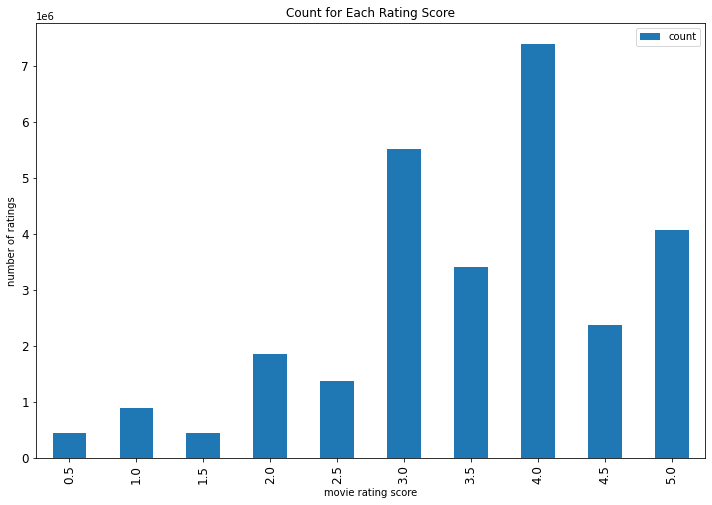

In [91]:
ax = df_ratings_cnt.plot(
    x='rating',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score',
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [92]:
# get rating frequency
df_movies_cnt = pd.DataFrame(ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,68469
2,27143
3,15585
4,2989
5,15474


Text(0, 0.5, 'number of ratings')

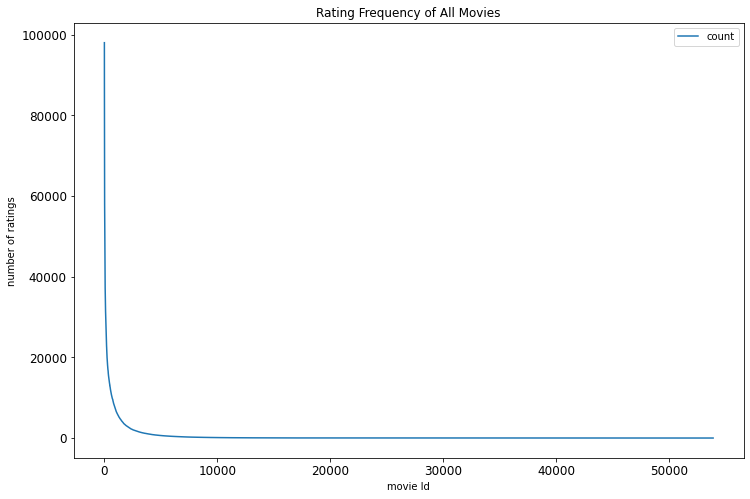

In [93]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

The distribution of ratings among movies often satisfies a property in real-world settings, which is referred to as the long-tail property. According to this property, only a small fraction of the items are rated frequently. Such items are referred to as popular items. The vast majority of items are rated rarely. This results in a highly skewed distribution of the underlying ratings.

Let's plot the same distribution but with log scale

Text(0, 0.5, 'number of ratings (log scale)')

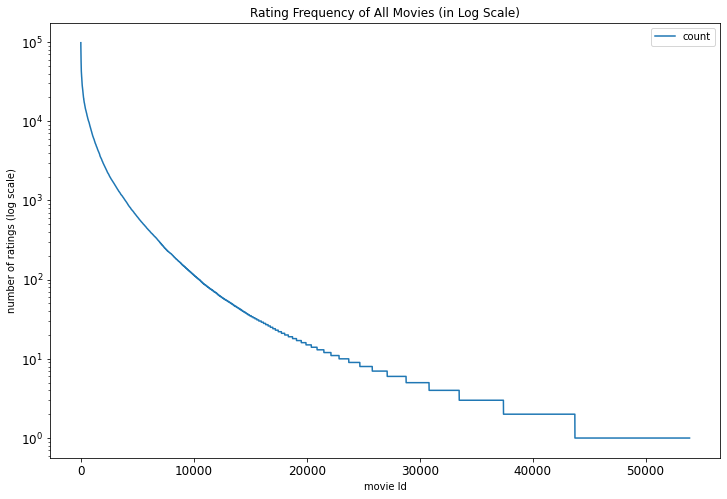

In [94]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

In [95]:
len(df_movies_cnt.loc[df_movies_cnt['count']<=10])

31033

In [96]:
num_items*.25

13472.25

We can see that 10500 out of 53.889 movies are rated more than 100 times. More interestingly, roughly 31,000 out of 53.889 movies are rated less than only 10 times. Let's look closer by displaying top quantiles of rating counts

In [97]:
df_movies_cnt['count'].quantile(np.arange(1, 0.7,-0.05))

1.00    97999.0
0.95    1855.0 
0.90    531.0  
0.85    205.0  
0.80    91.0   
0.75    48.0   
0.70    28.0   
Name: count, dtype: float64

So about 1% of movies have roughly 98.000 or more ratings, 5% have 1855 or more, and 20% have 100 or more. Since we have so many movies, we'll limit it to the top 20%. This is arbitrary threshold for popularity, but it gives us about 13.472 different movies. We still have pretty good amount of movies for modeling. As a result, we will not run into the MemoryError during model training and have improved recommendation quality with dropping out less known movies. 

In [98]:
# filter data
popularity_thres = 90
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = ratings[ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (27753444, 3)
shape of ratings data after dropping unpopular movies:  (27261949, 3)


In [99]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,16
2,15
3,11
4,736
5,72


Text(0, 0.5, 'number of ratings')

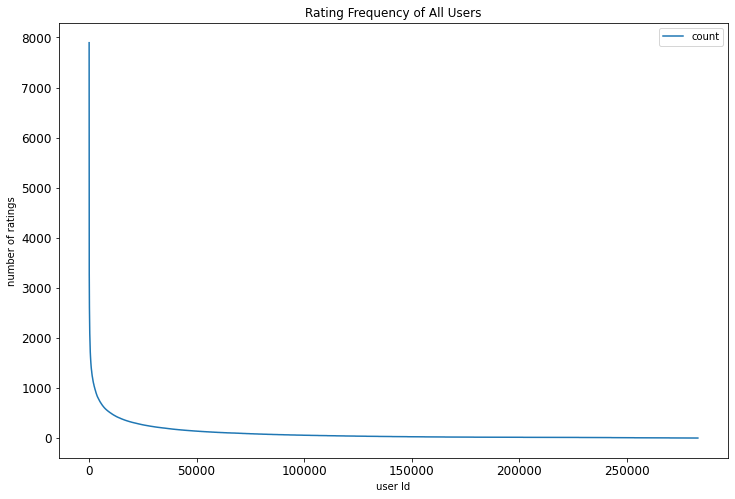

In [100]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [101]:
df_users_cnt['count'].quantile(np.arange(1, 0.3, -0.05))

1.00    7895.0
0.95    401.0 
0.90    239.0 
0.85    164.0 
0.80    121.0 
0.75    94.0  
0.70    73.0  
0.65    58.0  
0.60    47.0  
0.55    37.0  
0.50    30.0  
0.45    25.0  
0.40    20.0  
0.35    18.0  
Name: count, dtype: float64

In [102]:
num_users*.5

141614.0

We can see that the distribution of ratings by users is very similar to the distribution of ratings among movies. They both have long-tail property. Only a very small fraction of users are very actively engaged with rating movies that they watched. Vast majority of users aren't interested in rating movies. So we can limit users to the top 50%, which is about 141.614 users.

In [103]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (27753444, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (24010731, 3)


In [104]:
#modelleme icin kullanacagimiz temizlenmis yani reduced edilmis dataseti.
df_ratings_drop_users

,userId,movieId,rating
42,4,1,4.0
43,4,2,4.0
44,4,5,2.0
45,4,6,4.5
46,4,10,4.0
...,...,...,...
27753439,283228,8542,4.5
27753440,283228,8712,4.5
27753441,283228,34405,4.5
27753442,283228,44761,4.5


In [105]:
# we will use it in colloborative filtering
df_ratings_drop_users.to_csv('clean_rating_colloborative_filter.csv', index=False)

* now work on full train dataset

In [106]:
#merge my_tag_list and df_ratings_drop_users

In [107]:
movies = mv_tags_list.merge(df_ratings_drop_users, on = 'movieId')

In [108]:
movies

,movieId,Title,tag,userId,rating
0,1,Toy Story,"3d,action,adventure,affectionate,animal movie,animals,animated,animation,based on book,buddy movie,cartoon,catastrophe,cgi,chase,childhood,children,classic,clever,colourful,comedy,computer animation,cool,creativity,cute,cute!,destiny,dialogue,dinosaurs,disney,disney animated feature,entertaining,excellent,excellent script,exciting,family,fantasy,fast paced,feel good movie,feel-good,friendship,fun,fun movie,funny,good,good acting,good action,good soundtrack,good versus evil,great,great ending,great movie,happy ending,heartwarming,highly quotable,humor,humorous,imagination,imdb top 250,intense,interesting,kids,kids and family,light,masterpiece,mentor,monsters,nostalgic,original,original plot,oscar,oscar (best animated feature),oscar (best directing),oscar (best effects - visual effects),oscar (best writing - screenplay written directly for the screen),oscar winner,pixar,pixar animation,quotable,realistic,redemption,runaway,secrets,simple,story,storytelling,suprisingly clever,suspense,sweet,talking animals,talky,technology,touching,toys,unlikely friendships,very funny,very good,visual,visually stunning,whimsical,witty",4,4.0
1,1,Toy Story,"3d,action,adventure,affectionate,animal movie,animals,animated,animation,based on book,buddy movie,cartoon,catastrophe,cgi,chase,childhood,children,classic,clever,colourful,comedy,computer animation,cool,creativity,cute,cute!,destiny,dialogue,dinosaurs,disney,disney animated feature,entertaining,excellent,excellent script,exciting,family,fantasy,fast paced,feel good movie,feel-good,friendship,fun,fun movie,funny,good,good acting,good action,good soundtrack,good versus evil,great,great ending,great movie,happy ending,heartwarming,highly quotable,humor,humorous,imagination,imdb top 250,intense,interesting,kids,kids and family,light,masterpiece,mentor,monsters,nostalgic,original,original plot,oscar,oscar (best animated feature),oscar (best directing),oscar (best effects - visual effects),oscar (best writing - screenplay written directly for the screen),oscar winner,pixar,pixar animation,quotable,realistic,redemption,runaway,secrets,simple,story,storytelling,suprisingly clever,suspense,sweet,talking animals,talky,technology,touching,toys,unlikely friendships,very funny,very good,visual,visually stunning,whimsical,witty",10,5.0
2,1,Toy Story,"3d,action,adventure,affectionate,animal movie,animals,animated,animation,based on book,buddy movie,cartoon,catastrophe,cgi,chase,childhood,children,classic,clever,colourful,comedy,computer animation,cool,creativity,cute,cute!,destiny,dialogue,dinosaurs,disney,disney animated feature,entertaining,excellent,excellent script,exciting,family,fantasy,fast paced,feel good movie,feel-good,friendship,fun,fun movie,funny,good,good acting,good action,good soundtrack,good versus evil,great,great ending,great movie,happy ending,heartwarming,highly quotable,humor,humorous,imagination,imdb top 250,intense,interesting,kids,kids and family,light,masterpiece,mentor,monsters,nostalgic,original,original plot,oscar,oscar (best animated feature),oscar (best directing),oscar (best effects - visual effects),oscar (best writing - screenplay written directly for the screen),oscar winner,pixar,pixar animation,quotable,realistic,redemption,runaway,secrets,simple,story,storytelling,suprisingly clever,suspense,sweet,talking animals,talky,technology,touching,toys,unlikely friendships,very funny,very good,visual,visually stunning,whimsical,witty",14,4.5
3,1,Toy Story,"3d,action,adventure,affectionate,animal movie,animals,animated,animation,based on book,buddy movie,cartoon,catastrophe,cgi,chase,childhood,children,classic,clever,colourful,comedy,computer animation,cool,creativity,cute,cute!,destiny,dialogue,dinosaurs,disney,disney animated feature,entertaining,excellent,excellent script,exciting,family,fantasy,fast paced,feel good movie,feel-good,friendship,fun,fun movie,funny,good,good acting,good action,good soundtrack,good versus evil,great,g

In [109]:
movie_rating = movies.groupby('movieId')['rating'].agg(['count', 'mean']).reset_index()

In [110]:
movie_rating = movie_rating.rename(columns={'count': 'vote_count', 'mean': 'vote_average'})

In [111]:
movie_rating

,movieId,vote_count,vote_average
0,1,50580,3.880921
1,2,24376,3.216832
2,3,9479,3.086560
3,4,2603,2.831733
4,5,9520,3.011029
...,...,...,...
10809,185135,209,4.244019
10810,185585,300,2.801667
10811,186587,204,2.950980
10812,187593,1350,3.819259


In [112]:
temp = movies.drop_duplicates(subset=['movieId'])
temp = temp.drop(['userId','rating'],axis=1)

In [113]:
movie_rating = pd.merge(movie_rating, temp, on='movieId')

In [114]:
movie_rating

,movieId,vote_count,vote_average,Title,tag
0,1,50580,3.880921,Toy Story,"3d,action,adventure,affectionate,animal movie,animals,animated,animation,based on book,buddy movie,cartoon,catastrophe,cgi,chase,childhood,children,classic,clever,colourful,comedy,computer animation,cool,creativity,cute,cute!,destiny,dialogue,dinosaurs,disney,disney animated feature,entertaining,excellent,excellent script,exciting,family,fantasy,fast paced,feel good movie,feel-good,friendship,fun,fun movie,funny,good,good acting,good action,good soundtrack,good versus evil,great,great ending,great movie,happy ending,heartwarming,highly quotable,humor,humorous,imagination,imdb top 250,intense,interesting,kids,kids and family,light,masterpiece,mentor,monsters,nostalgic,original,original plot,oscar,oscar (best animated feature),oscar (best directing),oscar (best effects - visual effects),oscar (best writing - screenplay written directly for the screen),oscar winner,pixar,pixar animation,quotable,realistic,redemption,runaway,secrets,simple,story,storytelling,suprisingly clever,suspense,sweet,talking animals,talky,technology,touching,toys,unlikely friendships,very funny,very good,visual,visually stunning,whimsical,witty"
1,2,24376,3.216832,Jumanji,"action,action packed,adaptation,adapted from:book,adventure,alter ego,animal movie,animals,bad cgi,based on a book,based on a video game,based on book,big budget,bullying,catastrophe,cgi,chase,childhood,children,clever,comedy,computer animation,computer game,cool,creativity,destiny,dialogue,dinosaurs,dynamic cgi action,effects,entertaining,exciting,family,fantasy,fantasy world,fast paced,feel-good,fight scenes,first contact,fun,fun movie,girlie movie,good,good action,good versus evil,great,great ending,great movie,happy ending,high fantasy,intense,interesting,island,jungle,kids,kids and family,life philosophy,light,lions,mad scientist,magic,mentor,monkey,monster,mythology,natural disaster,nostalgic,not funny,original,original plot,orphans,oscar (best effects - visual effects),parallel universe,pg,pg-13,predictable,runaway,saturn award (best special effects),scary,science fiction,scifi,silly fun,special effects,spiders,story,storytelling,supernatural,suspense,swashbuckler,technology,time,time travel,transformation,video game,video games,videogame,visual,visuals,weird,witches"
2,3,9479,3.086560,Grumpier Old Men,"adaptation,adventure,bad plot,beautiful scenery,betrayal,brutality,california,catastrophe,chase,comedy,corruption,crappy sequel,criterion,crude humor,culture clash,death,destiny,dialogue,family,fantasy world,feel good movie,feel-good,fight scenes,fish,foul language,franchise,friendship,fun,fun movie,funny,girlie movie,good,good action,good sequel,good soundtrack,great,great acting,great ending,great movie,greed,gunfight,happy ending,hilarious,imdb top 250,indians,internet,justice,life philosophy,lone hero,marriage,melancholic,mentor,minnesota,multiple storylines,natural disaster,not funny,nudity (full frontal - brief),obsession,original,oscar (best directing),oscar winner,overrated,passionate,pg-13,pornography,predictable,prequel,redemption,relationships,revenge,romance,romantic comedy,runaway,script,sequel,sequels,sexy,shopping,silly,silly fun,slapstick,small town,so bad it's funny,stereotypes,story,storytelling,suprisingly clever,suspense,sweet,touching,twist ending,twists & turns,unfunny,unlikely friendships,vengeance,very funny,very good,wedding,weird,women"
3,4,2603,2.831733,Waiting to Exhale,"adaptation,adapted from:book,adultery,bad acting,bad plot,based on a book,based on book,betrayal,big budget,bittersweet,book,book was better,books,brutality,cancer,catastrophe,chase,cheating,chick flick,classic car,crude humor,cult film,culture clash,death,destiny,dialogue,divorce,drama,drinking,entirely dialogue,family,fantasy world,feel good movie,feel-good,fight scenes,first contact,friendship,gay,girlie movie,good,good soundtrack,great,great ending,happy ending,heartwarming,horrible,infidelity,interracial romanc

In [115]:
pickle.dump(movie_rating,open('movie_list.pkl','wb'))

In [116]:
pickle.dump(movie_rating.to_dict(),open('movie_dict.pkl','wb'))

In [117]:
pickle.dump(movies,open('movies_data.pkl','wb'))